# <u>TP4: Équations différentielles partielles</u>

## par Antoine Boissinot  - -  François Gaudreault  - -  Béatrice Lessard-Hamel

## Présenté à M. Philippe Després

### Date de remise : 4 avril 2021

In [1]:
import matplotlib.pylab as plt
import numpy as np
from numpy import matmul, exp, linspace, array, zeros, empty
import timeit
from scipy import constants
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
#Constants
hbar = constants.hbar #Planck's constant divided by 2*pi [m^2 kg / s]
M = constants.electron_mass #Mass of the electron [kg]
L = 1e-08 #Length of the box [m]
x_0 = L/2 # [m]
sigma = 10 ** -10 #[m]
kappa = 5 * 10 ** 10 #[m^-1]


## L'équation de Schrödinger et la méthode de Crank Nicolson

### Question 1
Le but de ce numéro est d'obtenir le vecteur $\mathbf{v}$ qui est donné par l'équation $\mathbf{B}\psi = \mathbf{v}$. Étant donné que la matrice $\mathbf{B}$ est une matrice tridiagonale, il est possible d'utiliser l'expression suivante pour obtenir les élément $v_i$ de $\mathbf{v}$: $$v_i = b_1 \psi_i + b_2(\psi_{i+1} + \psi_{i-1}).$$ Premièrement la fonction d'onde au temps t = 0 va être obtenue:

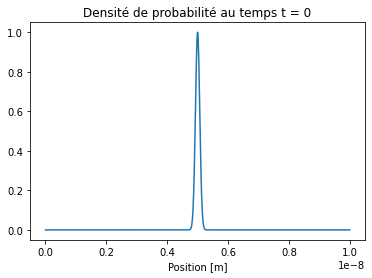

In [3]:
#Parameters of the simulation

N = 1000 #Number of spatial slice 
a = L/N  #Distance between each slice    
h = 10**(-18)  #Step [s]


def psi_0(x): #Return the initial wave function psi (x,0) at time t = 0 
    return exp(-(x - x_0) ** 2 / (2 * sigma ** 2)) * exp(1j * kappa * x)  


def initial_condition(N, L, h): #Set a wave function at time t = 0, with each point in x separated by a
    x = np.linspace(0, L, N+1) #Each point separated by a
    psi = np.array(psi_0(x)) #Initial condition  
    psi[0] = 0 #The wave function equal 0 at discontinuity point i.e. infinite potential value 
    psi[-1] = 0 #Same as last 
    return psi 
    
    
x = np.linspace(0, L, N+1) #Each point separated by a
psi_t0 = initial_condition(N, L, h)
plt.plot(x, abs(psi_t0)**2)
plt.title("Densité de probabilité au temps t = 0")
plt.xlabel("Position [m]")
plt.show()

Avant de poursuivre, la fonction d'onde étant de peu d'utilité en elle-même, c'est principalement la densité de probabilité qui va être tracé lors du TP, soit $|\psi(x)|^2$. Ceci dit, il est maintenant possible de de définir le vecteur $\mathbf{v}$: 

In [4]:
def v(psi): #return the vector v
    b1 = 1 - 1j * h * hbar / (2 * M * a ** 2)
    b2 = h * hbar * 1j / (4 * M * a ** 2)
    
    v = np.zeros(len(psi), dtype = complex) #Initialize the vector v 
    n = len(psi) - 1 #Last element of vector v 
    
    
    v[1:n] = b1 * psi[1:n] + b2 * (psi[2:n+1] + psi[0:n-1])
   
    
    return v


v_0 = v(psi_t0)

### Question 2
L'objet de ce numéro est de résoudre le système $\mathbf{v} = \mathbf{A}\mathbf{x}$ afin d'obtenir le vecteur $\mathbf{x}$. Pour ce faire l'algorithme de Thomas qui est une forme simplifiée de l'élimination gaussienne. On va premièrement écrire le vecteur sous la forme $$a_{i} x_{i-1}+b_{i} x_{i}+c_{i} x_{i+1}=d_{i}.$$  

In [5]:
def A_tri(N):
    a1 = 1 + 1j * h * hbar / (2 * M * a ** 2)
    a2 = - h * hbar * 1j / (4 * M * a ** 2)
    A = np.zeros([3, N + 1], dtype = complex) #We write the tridiagonal matrix in the good form 
    
    A[0, 0] = 0
    A[0, 1:] = a2
    A[1, :] = a1
    A[2, 0:N] = a2
    A[2, N] = 0
    return A 

M1 = A_tri(N)  

Ensuite, on utilise l'algorithme de Thomas pour résoudre le système. Brièvement, on invente des nouveaux coefficients $c_i^\prime$ et $d_i^\prime$ qui ont les valeurs suivantes:   
$$
c_{i}^{\prime}=\left\{\begin{array}{ll}
\frac{c_{i}}{b_{i}} & ; \quad i=1 \\
\frac{c_{i}}{b_{i}-a_{i} c_{i-1}^{\prime}} & ; \quad i=2,3, \ldots, n-1
\end{array}\right.
$$
et
$$
d_{i}^{\prime}=\left\{\begin{array}{ll}
\frac{d_{i}}{b_{i}} & ; \quad i=1 \\
\frac{d_{i}-a_{i} d_{i-1}^{\prime}}{b_{i}-a_{i} c_{i-1}^{\prime}} & ; \quad i=2,3, \ldots, n
\end{array}\right.
$$


On obtient alors la solution en utilisant les nouveaux coefficients: 
$$x_{n}=d_{n}^{\prime}$$
et 
$$
x_{i}=d_{i}^{\prime}-c_{i}^{\prime} x_{i+1} \quad ; i=n-1, n-2, \ldots, 1 .
$$ 

In [6]:
def Thomas(A_tri, v): 
    """
    The function returns the vector x of the system of equation Ax = v 
    param 1 A: is a triadiagonal matrix written in the form a_{i} * x_{i-1} + b_{i} * x_{i}+ c_{i} * x_{i+1}
    param 2 v: v is the vector of the RHS    
    return: x, the solution of the system  
    """
    N = len(v) - 1 
    c_prime = np.zeros(N, dtype = complex) #Initialization of the vector c' 
    d_prime = np.zeros(N + 1, dtype = complex) #Initialization of the vector d' 
    x = np.zeros(N + 1, dtype = complex) #Initialization of the vector x 
    
    a_ = A_tri[0, :] #Lower diagonal
    b_ = A_tri[1, :] #Middle diagonal
    c_ = A_tri[2, :] #Upper diagonal
    d_ = v[:] #RHS 
    
    c_prime[0] = c_[0]/b_[0] #First element of the new c' vector
    d_prime[0] = d_[0]/b_[0] #First element of the new d' vector
    
    for i in range(1, N):   
        c_prime[i] = c_[i]/(b_[i] - a_[i] * c_prime[i - 1]) #New values of c' 
    
    for i in range(1, N+1): 
        d_prime[i] = (d_[i] - a_[i] * d_prime[i-1])/(b_[i] - a_[i] * c_prime[i-1]) #New values of d'
    
    x[N] = d_prime[N] #Last element of the vector x 
    
    for i in range(N-1, -1, -1):
        x[i] = d_prime[i] - c_prime[i]*x[i+1] #New values of x by substitution of c' and d', from the before last to the first element

        
    return x


On peut vérifier si l'algorithme est fonctionnel en vérifiant si le produit matricielle et entre la matrice $\mathbf{A}$ et le vecteur $\mathbf{x}$ donne bien le vecteur $\mathbf{v}$. 

In [7]:
#First we must write the matrix A in its matrix form 

def A(N):
    
    A = np.zeros([N+1, N+1], dtype = complex) #We initialize the size of the square matrix
    a1 = 1 + 1j * h * hbar / (2 * M * a ** 2)
    a2 = - h * hbar * 1j / (4 * M * a ** 2)
    
    for i in range(N+1): #Middle diagonal
        A[i, i] = a1
    
    for i in range(N):   #Upper diagonal  
        A[i, i+1] = a2 
    
    for i in range(N):   #Lower diagonal
        A[i+1, i] = a2  
    
    return A

M2 = A(N)

#We check if the matrix product Ax = v 

x = Thomas(M1, v_0) #The vector x found by Thomas algorithm 
Ax = np.matmul(M2, x) #The matrix product

comparison = np.isclose(Ax,v_0)
equal_arrays = comparison.all() #If the value of equal_arrays is true then all the elements of Ax and v are the same 


if equal_arrays:
    print("Le vecteur de la multiplication matricielle Ax est à peu près égale au vecteur v.")

Le vecteur de la multiplication matricielle Ax est à peu près égale au vecteur v.


### Question 3


Maintenant, il est possible de répéter le processus plusieurs fois pour obtenir une nouvelle fonction d'onde à chaque incrément de temps h. 

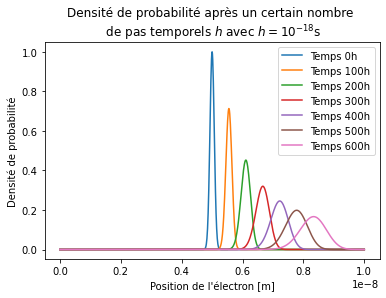

Pic de la densité de probabilité au temps 0: 1.00000
Pic de la densité de probabilité au temps 100: 0.71301
Pic de la densité de probabilité au temps 200: 0.45242
Pic de la densité de probabilité au temps 300: 0.32001
Pic de la densité de probabilité au temps 400: 0.24550
Pic de la densité de probabilité au temps 500: 0.19853
Pic de la densité de probabilité au temps 600: 0.16641


In [9]:
def psi(N, L, h, t):
    A = A_tri(N) 
    psi = initial_condition(N, L, h) #Initial wave function at time t = 0
    x_steps = np.linspace(0, L, N+1) 
    total_steps = int(t//h)  #Number of steps to reach time t
    solutiont =  [psi] #The list of the wave function array for each time t 
    for i in range(total_steps):
        v_vector = v(psi) #We compute v with our last wave function 
        psi = Thomas(A, v_vector) #New wave function psi at time t + h, by solving A*psi = v  
        solutiont.append(psi) 
    return x_steps, total_steps, solutiont 

t = 1600*h    # Enough time steps to have the first reflexion animated  
x_steps, total_steps, solutiont = psi(N, L, h, t)

#Plot a graph
for i in range(7):
    plt.plot(x_steps, abs(solutiont[i*100])**2, label = "Temps {}h".format(i*100)) 

plt.xlabel("Position de l'électron [m]")
plt.ylabel("Densité de probabilité")
plt.title("Densité de probabilité après un certain nombre \n de pas temporels $h$ avec $h = 10^{-18}$s")
plt.legend()
plt.show()

#print the peak values 
for i in range(7): 
    print("Pic de la densité de probabilité au temps {}".format(i*100) + ": {:.5f}".format(max(abs(solutiont[i*100])**2)))

Afin de mieux visualiser l'évolution de la fonction d'onde ainsi que celle de la densité de probabilité avec le temps une animation a été réalisée: 

#### Animation de la composante réelle de la fonction d'onde avec l'algorithme de Thomas

KeyboardInterrupt: 

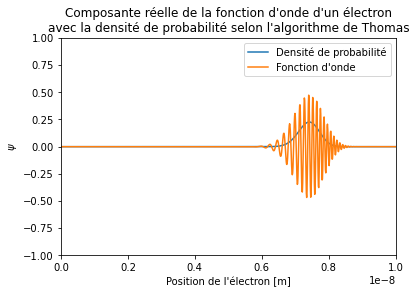

In [10]:
%matplotlib inline
plt.rcParams['animation.embed_limit'] = 2**128

#x_data = []
#y_data = []

"""
class matplotlib.animation.FuncAnimation(fig, func,
    frames=None, init_func=None, fargs=None, save_count=None, *, cache_frame_data=True, **kwargs)
"""

# Simulation Display Parameters

fig, ax = plt.subplots()
ax.set_xlim(0,1e-8)
ax.set_ylim(-1, 1)

line, = ax.plot([],[], label = 'Densité de probabilité')
line2, = ax.plot([],[], label = "Fonction d'onde")
ax.legend([line,line2], [line.get_label(), line2.get_label()])

ax.set_title("Composante réelle de la fonction d'onde d'un électron\navec la densité de probabilité selon l'algorithme de Thomas")
ax.set(xlabel="Position de l'électron [m]", ylabel='$\psi$')

# Initialization function 

def init():
    line.set_data([], [])
    return line, line2,

# Animation function of the imaginary component and probability density

def animation(i):
    x = x_steps
    ydens = abs(solutiont[i])**2
    yimag = np.real(solutiont[i])
    line.set_data(x, ydens)
    line2.set_data(x, yimag)
    
    
    return line, line2,


animation = FuncAnimation(fig, func=animation,init_func=init, frames=total_steps, interval=h*1000)
HTML(animation.to_jshtml())

### Question 4
À première vue, l'implémentation de l'algorithme de Thomas peut sembler exagéré, car plusieurs modules existent déjà tel que numpy.linalg qui permet de résoudre l'équation $\mathbf{Ax} = \mathbf{v}$ pour n'importe quel type de matrice. Néanmoins, utiliser les propriétés des matrices tridiagonales permet de sauver beaucoup de temps comme il va être démontré:      


In [11]:

def psi_linlag(N, L, h, t):
    psi = initial_condition(N, L, h) #Initial wave function at time t = 0
    x_steps = np.linspace(0, L, N+1) 
    total_steps = int(t//h)  #Number of steps to reach time t
    solutionla =  [psi]
    for i in range(total_steps):
        v_vector = v(psi)
        psi = np.linalg.solve(A(N), v_vector) #New wave function at time t + h  
        solutionla.append(psi) 
    return x_steps,total_steps, solutionla 

t = 750*h   # Enough time steps to have the first reflexion animated      
x_steps,total_steps, solutionla = psi(N, L, h, t)


for i in range(7): 
    print("Pic de la densité de probabilité au temps {}".format(i*100) + ": {:.5f}".format(max(abs(solutionla[i*100])**2)))


Pic de la densité de probabilité au temps 0: 1.00000
Pic de la densité de probabilité au temps 100: 0.71301
Pic de la densité de probabilité au temps 200: 0.45242
Pic de la densité de probabilité au temps 300: 0.32001
Pic de la densité de probabilité au temps 400: 0.24550
Pic de la densité de probabilité au temps 500: 0.19853
Pic de la densité de probabilité au temps 600: 0.16641


On peut voir que les valeurs maximales de densité de probabilité obtenues avec la fonction linalg de Numpy sont exactement les mêmes que celles obtenues avec la méthode de Thomas. Cela permet de valider que la fonction linlag a bien été utilisée. Il ne reste plus qu'à estimer le nombre de fois plus rapide qu'est l'algorithme de Thomas. 

In [12]:
t = 200*h # Time steps reduced to reduced the numbers of calculations

time_linlag = timeit.timeit('[psi_linlag(N, L, h, t)]', number = 1, globals=globals())
time_mat = timeit.timeit('[psi(N, L, h, t)]', number = 1, globals=globals())
Gain = (round(time_linlag/time_mat))

print("La fonction avec les opérations matricielles est environ {:.0f} fois plus rapide que la fonction avec les opérations numpy.linalg.".format(Gain))



La fonction avec les opérations matricielles est environ 13 fois plus rapide que la fonction avec les opérations numpy.linalg.


### Question 5

Ce qu'on observe sur l'animation est l'évolution de la fonction d'onde, celle-ci est une combinaison linéaire de l'état initial $\Psi(x,0)$ sur la base des différents états $\psi_n(x)$ du puit de potentiel infini. La fonction d'onde $\Psi(x,t)$ évolue ainsi: $$\Psi(x,t) = \sum^\infty_{n=1}c_n\psi_n(x)e^{-iE_nt/\hbar},$$ où $c_n$ sont des coefficients déterminés à partir de l'état initial et $E_n$ sont les niveaux d'énergies des différents états. C'est cette équation qui décrit le mouvement de la fonction d'onde. Lorsque la fonction d'onde frappe un des bords du puits de potentiel celle-ci est sans surprise réfléchie, phénomène affectant tout les types d'ondes lorsqu'ils rencontrent une interface. Il est à noter que celle-ci est entièrement réfléchie, aucune partie de la fonction traverse le potentiel. On pourrait se demander pourquoi l'effet tunnel n'a pas lieu. La raison est simple, le potentiel est infini et lorsque c'est le cas l'effet tunnel n'a pas lieu. [2]  

## Références
1. Newman, Mark. Computational physics. CreateSpace Independent Publ., 2013.
2. Griffiths, D. J. (2010). Introduction to quantum mechanics. Prentice Hall, second edi.